In [1]:
from bonsai.visualizer import plot_prune, scrape
from IPython.display import clear_output
import time

%load_ext autoreload
%autoreload 2

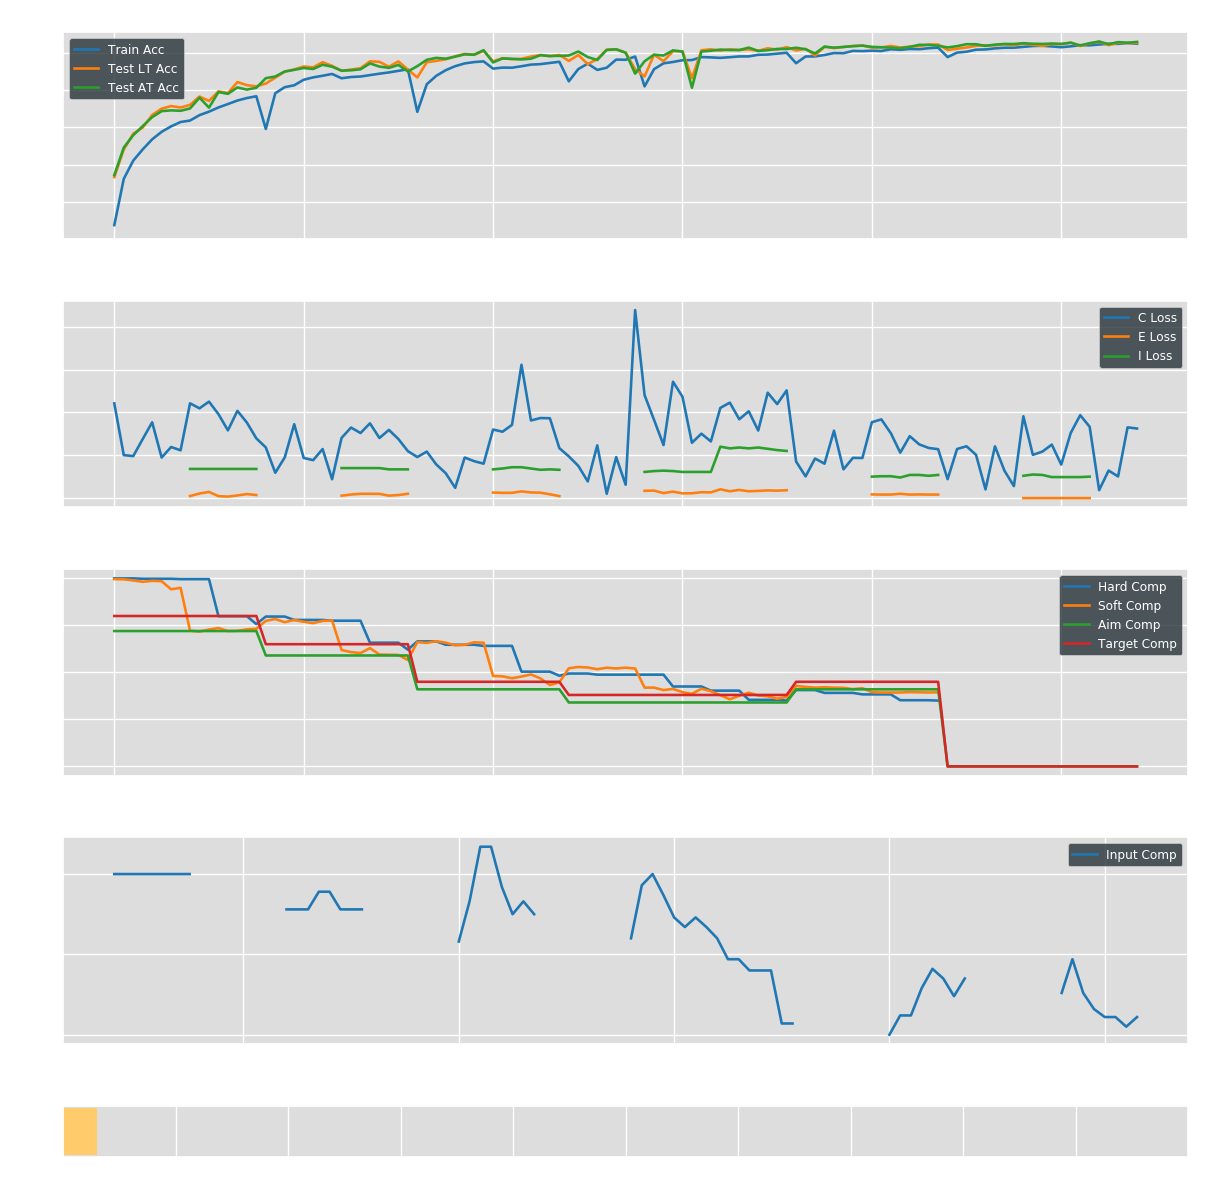

In [ ]:
curr_prog = 0
while 1:
    clear_output()
    plot_prune([10,10]) 
    new_prog = len(scrape()[0])
    while new_prog==curr_prog:
        time.sleep(15)
        new_prog = len(scrape()[0])
    curr_prog=new_prog